In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Load cleaned Chicago dataset ----
df = pd.read_csv("../dataset/clean_la.csv")  # adjust path


# ---- Keep top 10 most frequent crimes ----
top_crimes = df['Crime_Type'].value_counts().nlargest(10).index
df = df[df['Crime_Type'].isin(top_crimes)]

# ---- Select features ----
features = [
    'Latitude', 'Longitude', 'Zone', 'Hour', 'DayOfWeek',
    'IsWeekend', 'Light_Condition', 'Temperature', 'Rain'
]
X = df[features].copy()
y = df['Crime_Type']

# ---- Encode categorical columns (like DayOfWeek or Light_Condition) ----
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

# ---- Balance classes ----
df_balanced = pd.concat([
    resample(df[df['Crime_Type'] == c],
             replace=True,
             n_samples=df['Crime_Type'].value_counts().max(),
             random_state=42)
    for c in top_crimes
])
X = df_balanced[features].copy()
y = df_balanced['Crime_Type']

for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

# ---- Encode target ----
target_le = LabelEncoder()
y_encoded = target_le.fit_transform(y)

# ---- Scale ----
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---- Split ----
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# ---- Grid Search ----
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='accuracy', cv=3, n_jobs=-1)
grid.fit(X_train, y_train)

best_knn = grid.best_estimator_
print("Best parameters:", grid.best_params_)



Best parameters: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}



Optimized KNN Accuracy: 73.13%

Classification Report:
                                                         precision    recall  f1-score   support

         ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       0.73      0.83      0.78     36087
                               BATTERY - SIMPLE ASSAULT       0.71      0.60      0.65     36086
                                               BURGLARY       0.73      0.69      0.71     36087
                                  BURGLARY FROM VEHICLE       0.72      0.66      0.69     36087
                      INTIMATE PARTNER - SIMPLE ASSAULT       0.73      0.77      0.75     36087
                                      THEFT OF IDENTITY       0.75      0.79      0.77     36087
                     THEFT PLAIN - PETTY ($950 & UNDER)       0.72      0.69      0.70     36087
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)       0.73      0.78      0.76     36087
               VANDALISM - MISDEAMEANOR ($399 OR UNDER)       0.74    

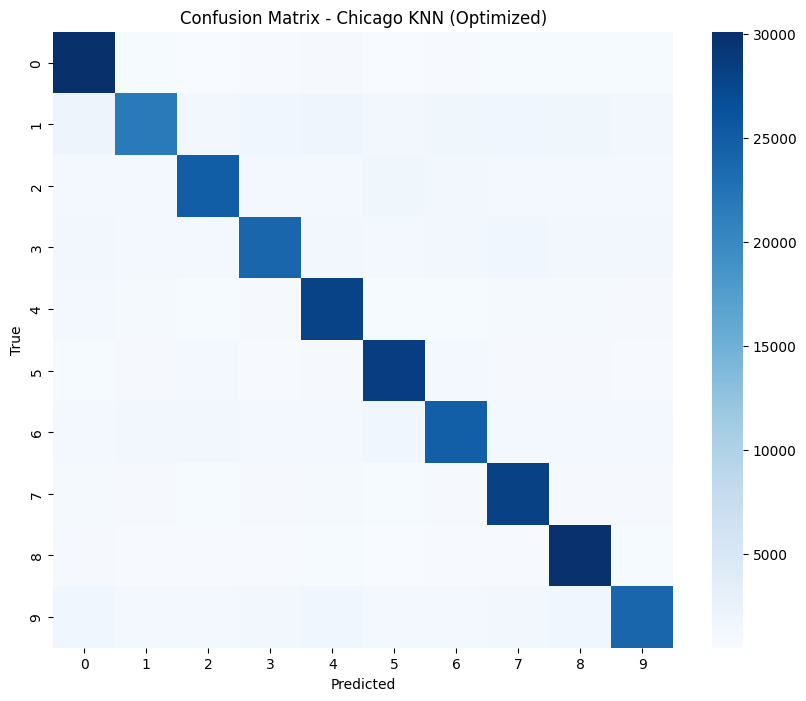

In [3]:
# ---- Train & Evaluate ----
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nOptimized KNN Accuracy: {acc:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_le.classes_))

# ---- Confusion Matrix ----
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_pred), cmap="Blues", annot=False)
plt.title("Confusion Matrix - Chicago KNN (Optimized)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [4]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred, target_names=target_le.classes_))


Random Forest Accuracy: 0.6034311715086957
                                                         precision    recall  f1-score   support

         ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       0.61      0.71      0.66     36087
                               BATTERY - SIMPLE ASSAULT       0.61      0.46      0.53     36086
                                               BURGLARY       0.57      0.57      0.57     36087
                                  BURGLARY FROM VEHICLE       0.55      0.58      0.57     36087
                      INTIMATE PARTNER - SIMPLE ASSAULT       0.64      0.61      0.63     36087
                                      THEFT OF IDENTITY       0.52      0.76      0.62     36087
                     THEFT PLAIN - PETTY ($950 & UNDER)       0.56      0.57      0.57     36087
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)       0.74      0.58      0.65     36087
               VANDALISM - MISDEAMEANOR ($399 OR UNDER)       0.79      0.62      0

In [5]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier(
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=200,
    objective='multiclass',
    random_state=42
)
lgbm.fit(X_train, y_train)
lgb_pred = lgbm.predict(X_test)

print("LightGBM Accuracy:", accuracy_score(y_test, lgb_pred))
print(classification_report(y_test, lgb_pred, target_names=target_le.classes_))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 1443472, number of used features: 9
[LightGBM] [Info] Start training from score -2.302586
[LightGBM] [Info] Start training from score -2.302580
[LightGBM] [Info] Start training from score -2.302586
[LightGBM] [Info] Start training from score -2.302586
[LightGBM] [Info] Start training from score -2.302586
[LightGBM] [Info] Start training from score -2.302586
[LightGBM] [Info] Start training from score -2.302586
[LightGBM] [Info] Start training from score -2.302586
[LightGBM] [Info] Start training from score -2.302580
[LightGBM] [Info] Start training from score -2.302586


/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.24776095414389748
                                                         precision    recall  f1-score   support

         ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       0.21      0.31      0.25     36087
                               BATTERY - SIMPLE ASSAULT       0.22      0.12      0.16     36086
                                               BURGLARY       0.25      0.30      0.27     36087
                                  BURGLARY FROM VEHICLE       0.24      0.31      0.27     36087
                      INTIMATE PARTNER - SIMPLE ASSAULT       0.20      0.18      0.19     36087
                                      THEFT OF IDENTITY       0.34      0.59      0.43     36087
                     THEFT PLAIN - PETTY ($950 & UNDER)       0.27      0.31      0.29     36087
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)       0.21      0.07      0.10     36087
               VANDALISM - MISDEAMEANOR ($399 OR UNDER)       0.27      0.05      0.09 

In [6]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, n_jobs=-1)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_pred))
print(classification_report(y_test, lr_pred, target_names=target_le.classes_))


/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:336: RuntimeWarning: divide by zero encountered in matmul
  grad[:, :n_features] = grad_pointwise.T @ X + l2_reg_strength * weights
/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linea

Logistic Regression Accuracy: 0.16793398140040125
                                                         precision    recall  f1-score   support

         ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       0.16      0.30      0.21     36087
                               BATTERY - SIMPLE ASSAULT       0.13      0.04      0.06     36086
                                               BURGLARY       0.15      0.07      0.09     36087
                                  BURGLARY FROM VEHICLE       0.16      0.25      0.20     36087
                      INTIMATE PARTNER - SIMPLE ASSAULT       0.14      0.08      0.10     36087
                                      THEFT OF IDENTITY       0.20      0.63      0.30     36087
                     THEFT PLAIN - PETTY ($950 & UNDER)       0.14      0.22      0.17     36087
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)       0.11      0.00      0.00     36087
               VANDALISM - MISDEAMEANOR ($399 OR UNDER)       0.13      0.00

/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [7]:
results = {
    "Model": ["KNN", "Random Forest", "LightGBM", "Logistic Regression"],
    "Accuracy": [
        accuracy_score(y_test, y_pred),  # KNN
        accuracy_score(y_test, rf_pred),
        accuracy_score(y_test, lgb_pred),
        accuracy_score(y_test, lr_pred)
    ]
}

comparison = pd.DataFrame(results)
print("\nModel Comparison:")
print(comparison)



Model Comparison:
                 Model  Accuracy
0                  KNN  0.731342
1        Random Forest  0.603431
2             LightGBM  0.247761
3  Logistic Regression  0.167934


/var/folders/40/xpskrwgs1l1734zl9j0227hw0000gn/T/ipykernel_54675/3223309771.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette="Blues_d")


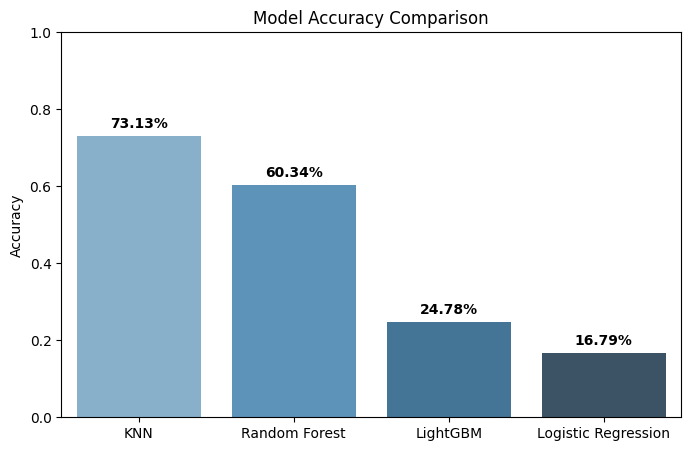

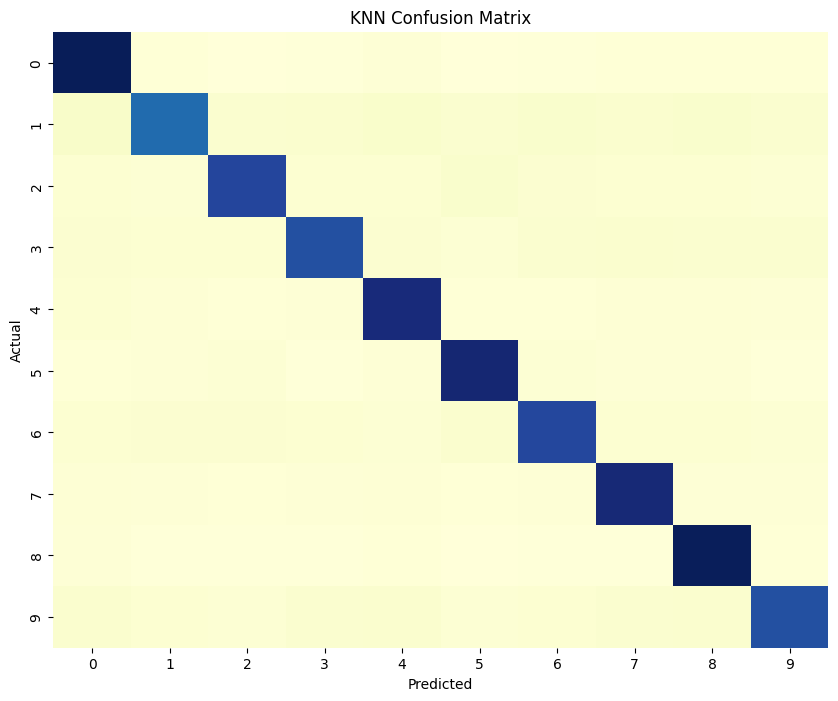

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Accuracy Bar Chart ---
models = ["KNN", "Random Forest", "LightGBM", "Logistic Regression"]
accuracies = [
    accuracy_score(y_test, y_pred),       # KNN
    accuracy_score(y_test, rf_pred),
    accuracy_score(y_test, lgb_pred),
    accuracy_score(y_test, lr_pred)
]

plt.figure(figsize=(8,5))
sns.barplot(x=models, y=accuracies, palette="Blues_d")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center', fontweight='bold')
plt.show()

# --- Confusion Matrix for KNN (best model) ---
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="YlGnBu", cbar=False)
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


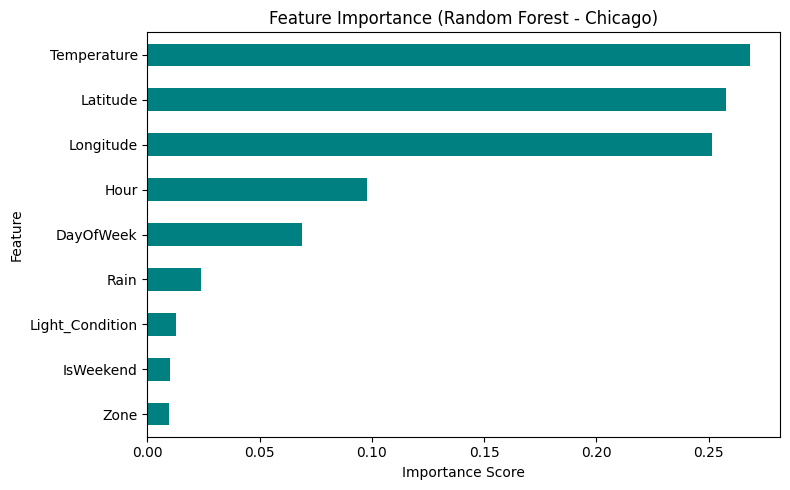

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Get importance scores
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=True)

# Plot
plt.figure(figsize=(8,5))
feat_imp.plot(kind='barh', color='teal')
plt.title("Feature Importance (Random Forest - Chicago)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [10]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=target_le.classes_, columns=target_le.classes_)
cm_df["Most Confused With"] = cm_df.apply(lambda row: row.drop(row.name).idxmax(), axis=1)
print("Top Confusions:")
print(cm_df["Most Confused With"].head(10))


Top Confusions:
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT                             INTIMATE PARTNER - SIMPLE ASSAULT
BATTERY - SIMPLE ASSAULT                                      ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
BURGLARY                                                                                   THEFT OF IDENTITY
BURGLARY FROM VEHICLE                                      VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...
INTIMATE PARTNER - SIMPLE ASSAULT                             ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
THEFT OF IDENTITY                                                                                   BURGLARY
THEFT PLAIN - PETTY ($950 & UNDER)                                                         THEFT OF IDENTITY
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)       ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
VANDALISM - MISDEAMEANOR ($399 OR UNDER)                      ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
VEH

In [11]:
import joblib

# Save KNN model
joblib.dump(best_knn, "../models/knn_sa.pkl")

# Save scaler
joblib.dump(scaler, "../models/scaler_sa.pkl")

print("✅ KNN model and scaler saved successfully!")


✅ KNN model and scaler saved successfully!
